In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import datetime
import matplotlib.pyplot as plt
from matplotlib import pyplot
import folium
import imageio
from tqdm import tqdm_notebook
from folium.plugins import MarkerCluster
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs

import mapclassify as mc
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import scipy
from itertools import product
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 
          'xkcd:sea blue', 
          'xkcd:pale red', 
          'xkcd:sage green', 
          'xkcd:terra cotta', 
          'xkcd:dull purple', 
          'xkcd:teal', 
          'xkcd: goldenrod', 
          'xkcd:cadet blue',
          'xkcd:scarlet']

In [2]:
data = pd.read_csv('prismc-tmax-daily-40_-120.csv')

In [3]:
data.head()

,date,value
0,1981-01-01,55.08 deg_F
1,1981-01-02,51.48 deg_F
2,1981-01-03,51.87 deg_F
3,1981-01-04,45.09 deg_F
4,1981-01-05,48.72 deg_F


In [4]:
data.index

RangeIndex(start=0, stop=15076, step=1)

In [5]:
#Remove " deg_F"s from value strings
data['value'] = data['value'].apply(lambda x: x.rstrip(" deg_F"))
data.head()

,date,value
0,1981-01-01,55.08
1,1981-01-02,51.48
2,1981-01-03,51.87
3,1981-01-04,45.09
4,1981-01-05,48.72


In [6]:
data = data.rename(columns = {'date' : 'Date', 'value' : "Deg F"})
data.head()

,Date,Deg F
0,1981-01-01,55.08
1,1981-01-02,51.48
2,1981-01-03,51.87
3,1981-01-04,45.09
4,1981-01-05,48.72


In [7]:
type(data['Deg F'][0])

str

In [8]:
data['Date'][0]

'1981-01-01'

In [9]:
# Convert max temperature strings to floats
data['Deg F'] = data['Deg F'].astype(float)
data.head()

,Date,Deg F
0,1981-01-01,55.08
1,1981-01-02,51.48
2,1981-01-03,51.87
3,1981-01-04,45.09
4,1981-01-05,48.72


In [10]:
# Check conversion
type(data['Deg F'][0])

numpy.float64

In [11]:
last = len(data['Deg F'])
type(data['Deg F'][last-1])

numpy.float64

In [12]:
print('The datasets lowest observation is '+repr(min(data['Deg F'])) +' and the highest observation is '+ repr(max(data['Deg F'])))

The datasets lowest observation is 11.13 and the highest observation is 102.71


In [13]:
#Check date column values' dtype
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15076 entries, 0 to 15075
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    15076 non-null  object 
 1   Deg F   15076 non-null  float64
dtypes: float64(1), object(1)
memory usage: 235.7+ KB


In [14]:
#convert Date values to datetime object
data['Date'] = data['Date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))
data.info()

#chicago_data.dt = pd.to_datetime(chicago_data.dt)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15076 entries, 0 to 15075
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    15076 non-null  datetime64[ns]
 1   Deg F   15076 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 235.7 KB


In [15]:
# Create separate columns for date data
YEAR = []
MONTH = []
DAY = []
WEEKDAY = []
for i in range(len(data.Date)):
    WEEKDAY.append(data.Date[i].weekday())
    DAY.append(data.Date[i].day)
    MONTH.append(data.Date[i].month)
    YEAR.append(data.Date[i].year)

In [16]:
data['Year'] = YEAR
data['Month'] = MONTH
data['Day'] = DAY 
data['Weekday'] = WEEKDAY

In [17]:
change_year_index = []
change_year = []
year_list = data['Year'].tolist()
for y in range(0,len(year_list)-1):
    if year_list[y]!=year_list[y+1]:
        change_year.append(year_list[y+1])
        change_year_index.append(y+1)

In [18]:
x_ticks_year_list=np.linspace(min(year_list),max(year_list),10).astype(int)
change_year_index = np.array(change_year_index)
x_ticks_year_index = []
for i in range(1,len(x_ticks_year_list)):
    x_ticks_year_index.append(change_year_index[np.where(np.array(change_year)==x_ticks_year_list[i])][0])

In [19]:
len(x_ticks_year_index)

9

ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of ticklabels (10).

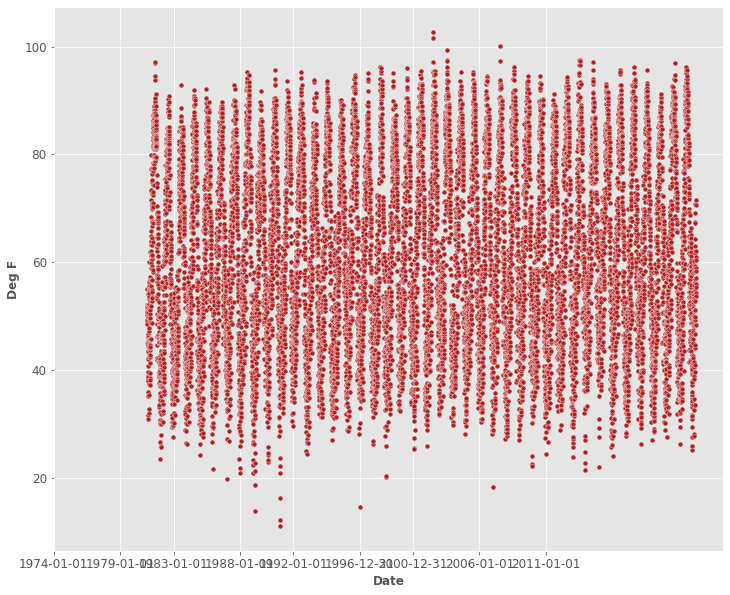

In [20]:
sns.scatterplot(x=data['Date'],y=data['Deg F'],s=25,color='firebrick')
plt.xticks(x_ticks_year_index,x_ticks_year_list)
plt.title('Max Temperature vs Year Scatter plot',color='firebrick',fontsize=40)
plt.xlabel('Year')
plt.ylabel('Max Temperature')

In [26]:
len(data['Deg F'])

15076

In [27]:
# Manual StDev calc
std_dev = data['Deg F'].std()
std_dev

17.518544068745495

In [28]:
data['Deg F'].describe()

count    15076.000000
mean        61.326343
std         17.518544
min         11.130000
25%         46.790000
50%         59.820000
75%         77.210000
max        102.710000
Name: Deg F, dtype: float64

In [30]:
# !!!!!!!!!!!!!!
train_data = data[3287:6939]

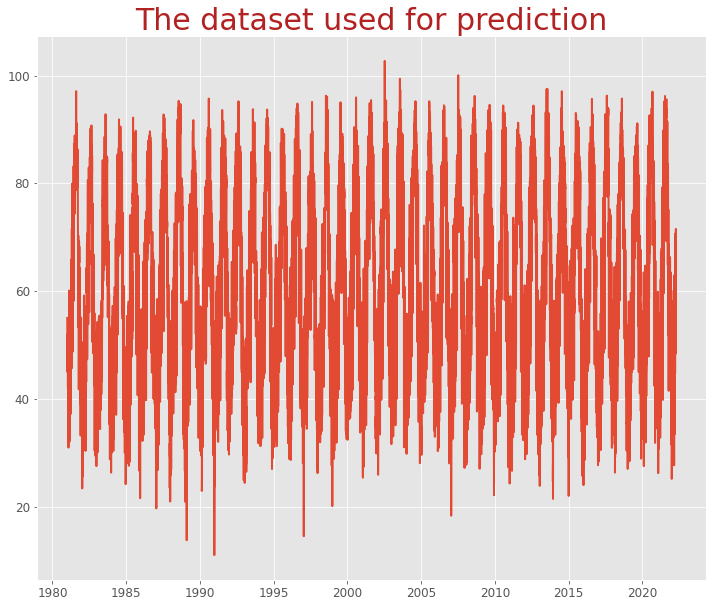

In [31]:
plt.title('The dataset used for prediction', fontsize=30, color='firebrick')
plt.plot(data['Date'], data['Deg F'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


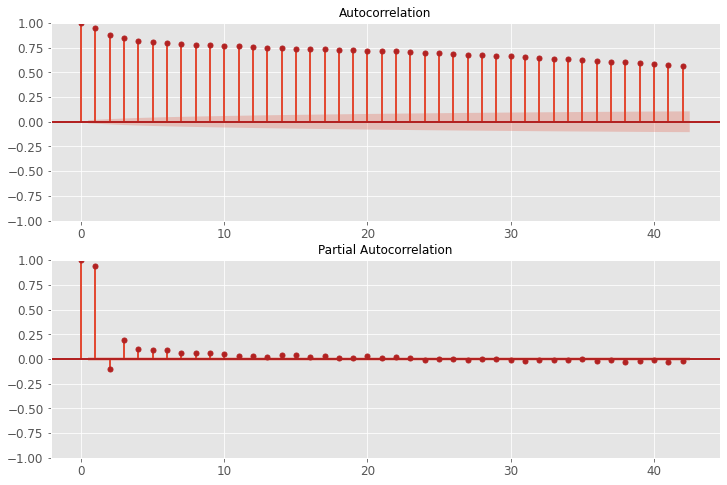

In [21]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Deg F'], ax=ax1,color ='firebrick')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Deg F'], ax=ax2,color='firebrick')

## Our dataset appears to be stationary, but we can confirm this with an AD Fuller test

In [29]:
#AD Fuller Test - full data 
result = adfuller(data['Deg F'])
print('ADF Statistic on the temp var: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the temp var: -9.189001070353388
p-value: 2.1486042570347297e-15
Critical Values:
	1%: -3.4307850995899374
	5%: -2.8617322952263824
	10%: -2.566872354102449


In [24]:
# The above Test's p-value shows the full data set is stationary.
# Looking at just the 1990s as a slice to perform another AD Fuller test.
result_90s = adfuller(data['Deg F'][3287:6939])

print('ADF Statistic on the temp var: {}'.format(result_90s[0]))
print('p-value: {}'.format(result_90s[1]))
print('Critical Values:')
for key, value in result_90s[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the temp var: -3.803694547327359
p-value: 0.002869740327553104
Critical Values:
	1%: -3.4321522387754775
	5%: -2.862336328589075
	10%: -2.567193897993964


## The low p-values above help confirm our data is stationary

### Performing the train/test split:


In [25]:
temp = data['Deg F']
N = len(data['Deg F'])
split = 0.95
training_size = round(split*N)
test_size = round((1-split)*N)
series = data['Deg F'][:training_size]
date = data['Date'][:training_size]
test_series = data['Deg F'][len(date)-1:len(temp)]
test_date = data['Date'][len(date)-1:len(temp)]
test_date = test_date.reset_index().Date
test_series = test_series.reset_index()['Deg F']

In [27]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        #try: 
        model = SARIMAX(exog, order=order).fit(disp=-1)
    #except:
    #        continue
            
        aic = model.aic
        results.append([order, model.aic])
    #print(results)
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

### Zero-differentiated ARIMA models - (using AIC)

In [ ]:
ps = range(0, 10, 1)
d = 0
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_0 = optimize_ARIMA(order_list, exog = series)

/var/folders/k1/btj9rqj50h33wypkg41zpbkm0000gn/T/ipykernel_5175/912339691.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/100 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Chec

In [ ]:
result_d_0.head()

### First differentiated models

In [ ]:
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_1 = optimize_ARIMA(order_list, exog = series)

result_d_1

In [ ]:
result_d_1.head()

The total summary is highlighted with this function and it shows that the (2,1,8) model and the (5,1,3) model 
are the best ones.


In [ ]:
final_result = result_d_0.append(result_d_1)

In [ ]:
best_models = final_result.sort_values(by='AIC', ascending=True).reset_index(drop=True).head()

In [ ]:
best_models.head()

In [ ]:
best_model_params_0 = best_models[best_models.columns[0]][0]
best_model_params_1 = best_models[best_models.columns[0]][1]

In [ ]:
best_model_0 = SARIMAX(series, order=best_model_params_0).fit()
print(best_model_0.summary())
best_model_1 = SARIMAX(series, order=best_model_params_1).fit()
print(best_model_1.summary())

### (2, 1, 8) Model

In [ ]:
best_model_0.plot_diagnostics(figsize=(15,12))
plt.show()

### (5, 1, 3) Model

In [ ]:
best_model_1.plot_diagnostics(figsize=(15,12))
plt.show()

# Forecasting

In [ ]:
fore_l= test_size-1
forecast = best_model_0.get_prediction(start=training_size, end=training_size+fore_l)
forec = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05) 

In [ ]:
#***MATTHEW LOOK HERE -------------------------------*
# in the example I followed, their dataset had an uncertainty measurement in the raw data in each observation
# that is what they used here in the error testing where I've just plugged the data inself back in - data['Deg F']
#What do I doooooooooooo
error_test=data.loc[test_date[1:].index.tolist()]['Deg F']
index_test = test_date[1:].index.tolist()
test_set = test_series[1:]

In [ ]:
lower_test = test_set-error_test
upper_test = test_set+error_test

In [ ]:
fig, ax = plt.subplots(figsize=(16,8), dpi=300)
x0 = data['Deg F'].index[0:training_size]
x1=data['Deg F'].index[training_size:training_size+fore_l+1]
ax.fill_between(forec, ci['lower Load'], ci['upper Load'])
plt.plot(x0, data['Deg F'][0:training_size],'k', label = 'Max Temperature')

plt.plot(data['Deg F'][training_size:training_size+fore_l], '.k', label = 'Actual')

forec = pd.DataFrame(forec, columns=['f'], index = x1)
forec.f.plot(ax=ax,color = 'Darkorange',label = 'Forecast (d = 2)')
ax.fill_between(x1, ci['lower AverageTemperature'], ci['upper AverageTemperature'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')

forec = pd.DataFrame(columns=['f'], index = x1)
forec.f.plot(ax=ax,color = 'firebrick',label = 'Forecast  (2,1,5) model')
ax.fill_between(x1, ci['lower AverageTemperature'], ci['upper AverageTemperature'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')


plt.legend(loc = 'upper left')
plt.xlim(120,265)
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')
plt.show()

In [ ]:
#Ignore this
plt.fill_between(np.arange(0,len(test_set),1), lower_test, upper_test,alpha=0.2, label = 'Test set error range',color='navy')
plot_from_data(test_set,test_date,c='navy',label='Actual')
plot_from_data(forec['f'],test_date,c='firebrick',label='Forecast')
plt.legend(loc=2)